In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import sin, asin, floor, sqrt, pi
import numpy as np
from scipy.linalg import sqrtm, fractional_matrix_power
from qiskit.circuit.library import CRXGate



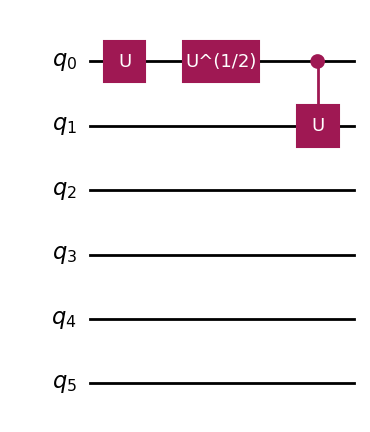

In [8]:
U = np.array([
    [1, 0],
    [0, -1]
])

U_sqrt = sqrtm(U)

u_gate = UnitaryGate(U, label="U")
u_sqrt_gate = UnitaryGate(U_sqrt, label="U^(1/2)")
cu_gate = u_gate.control(1)

# Custom color style
style = {
    "displaycolor": {"U": ("#168A2F", "#000000")}  # (gate fill color, text color)
}


qc = QuantumCircuit(6, name="circuit")
qc.append(u_gate, [0])
qc.append(u_sqrt_gate, [0])
qc.append(cu_gate, [0, 1])
qc.draw(output="mpl")

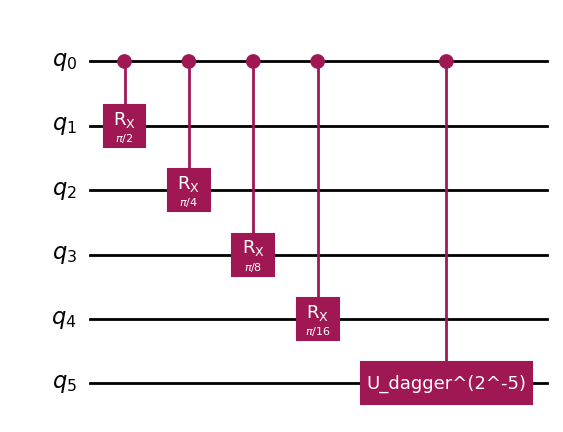

In [39]:
def c_phase_sqrt_u(n: int, m: int, U):
    
    ans = QuantumCircuit(m + 2)

    if m == n - 1:
        for j in range(m):
            ans.append(CRXGate(pi/(2**(j))), [0, j + 1])
            
        cu_gate = UnitaryGate(U, label=f"U^(2^-{m})").control(1)
        ans.append(cu_gate, [0, m + 1])
    else:
        for j in range(m):
            ans.append(CRXGate(pi/(2**(j + 1))), [0, j + 1])

        cu_gate = UnitaryGate(U, label=f"U^(2^-{m + 1})").control(1)
        ans.append(cu_gate, [0, m + 1])

    return ans

def c_phase_sqrt_u_dagger(n: int, m: int, U):
    
    ans = QuantumCircuit(m + 2)
    U = U.conj().T

    for j in range(m):
        ans.append(CRXGate(pi/(2**(j + 1))), [0, j + 1])

    cu_gate = UnitaryGate(U, label=f"U_dagger^(2^-{m + 1})").control(1)
    ans.append(cu_gate, [0, m + 1])
        
    return ans

U = np.array([
    [1, 0],
    [0, -1]
])
c_phase_sqrt_u_dagger(5, 4, U).draw(output="mpl", style=style)

In [23]:
ans = QuantumCircuit(2)
ans.append(CRXGate(pi/(2**(1))), [0, 1])

In [33]:
list(range(0, 5))

[0, 1, 2, 3, 4]